In [1]:
import torch
import matplotlib.pyplot as plt
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

train_dataloader, train_sub_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders(sub_dataloader_size=20_000)

/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/utils/data_utils.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
saved_network_path = "../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl"
trained_network = ut.load_network(saved_network_path)

Loading network from '../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl'
Network successfully loaded from '../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl'


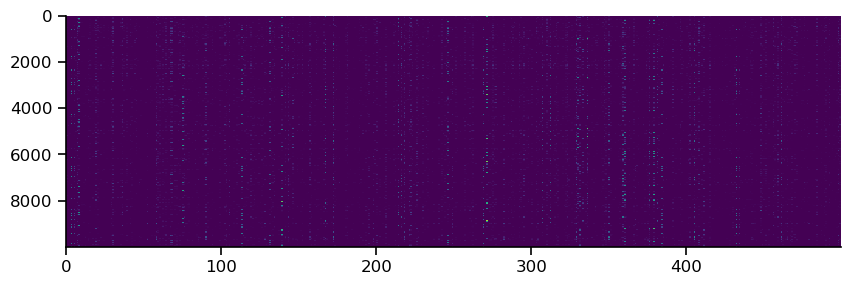

In [3]:
plt.imshow(trained_network.H2.E.activity, aspect="auto", interpolation="nearest")

Batch accuracy = 92.44000244140625%


/Users/ag1880/github-repos/Milstein-Lab/EIANN/EIANN/plot.py:772: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


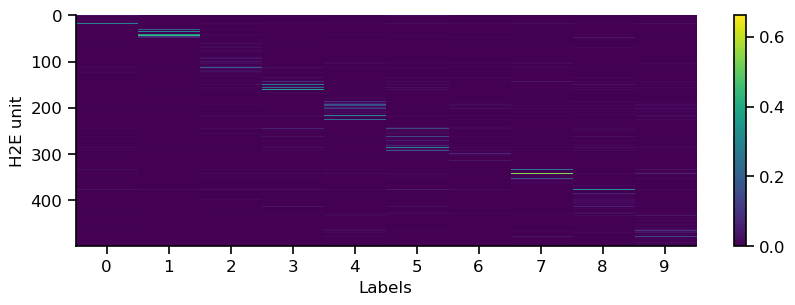

In [4]:
pt.plot_batch_accuracy(trained_network, test_dataloader, population='H2E')

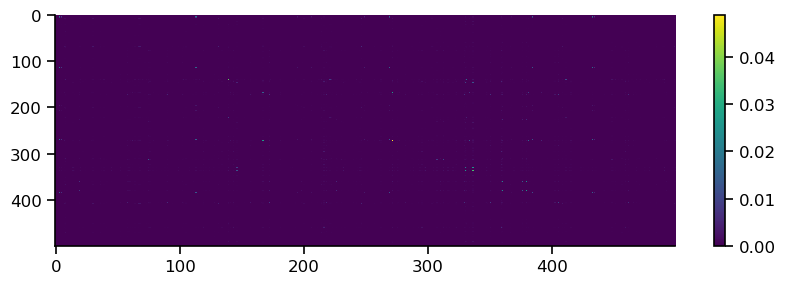

In [5]:
H2_act = trained_network.H2.E.activity
cov_mat = torch.matmul(H2_act.T, H2_act) / H2_act.shape[0]
plt.imshow(cov_mat, aspect="auto", interpolation="nearest")
plt.colorbar()

In [6]:
w = trained_network.Output.E.H2.E.weight.data
# w = torch.empty(10,500).log_normal_(0,2)
pred_B = cov_mat@w.T

cov_matrix = np.cov(H2_act.T)
U, S, V = np.linalg.svd(cov_matrix)
w2 = U[:,0:10].T # Take the first 10 eigenvectors
pred_B2 = cov_mat@w2.T

# plt.scatter(w.flatten(), pred_B.flatten(), s=1)
# plt.xlabel("True weight")
# plt.ylabel("Predicted weight")


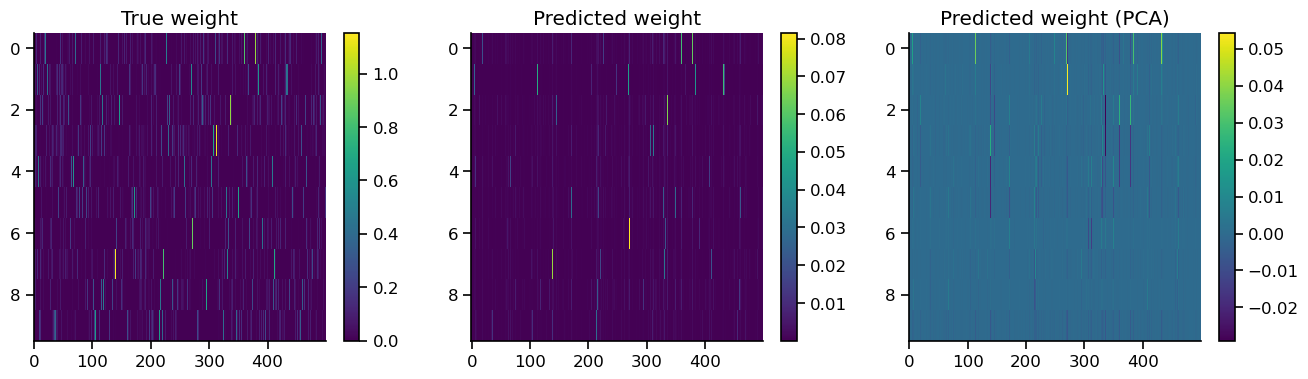

In [7]:
fig,ax  = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(w, aspect="auto", interpolation="nearest")    
ax[0].set_title("True weight")
plt.colorbar(im)

im = ax[1].imshow(pred_B.T, aspect="auto", interpolation="nearest")
ax[1].set_title("Predicted weight")
plt.colorbar(im)

im = ax[2].imshow(pred_B2.T, aspect="auto", interpolation="nearest")
ax[2].set_title("Predicted weight (PCA)")
plt.colorbar(im)

plt.show()

In [8]:
config_path = "../network_config/MNIST_templates/Simple_1layer_learnTD_HWN.yaml"
network = ut.build_EIANN_from_config(config_path, network_seed=66049)

dim = 5
x_ = np.linspace(-5, 5, dim)
mu = 0
std = 1
gaussian = np.exp(-0.5 * ((x_ - mu) / std) ** 2)

data = []
for idx in range(100):
    # sample_data = torch.empty(dim).log_normal_(0, 1)
    # sample_data = torch.empty(dim).uniform_(-1, 1)
    sample_data = torch.eye(dim)[torch.randint(0, dim, (1,))].squeeze()
    # sample_data = torch.randn(dim)
    # sample_data = torch.tensor(np.roll(gaussian, torch.randint(0, dim, (1,)))).float()

    sample_target = torch.rand(10)
    data.append([idx, sample_data, sample_target])
train_dataloader = torch.utils.data.DataLoader(data, shuffle=True, generator=data_generator, batch_size=1)

network.train(train_dataloader, 
                epochs=1,
                val_interval=(0,-1,1),
                store_history=True, 
                store_params=True,
                status_bar=True)

# FF_FB_angles = ut.compute_feedback_weight_angle_history(network, plot=True)


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/100 [00:00<?, ?it/s]

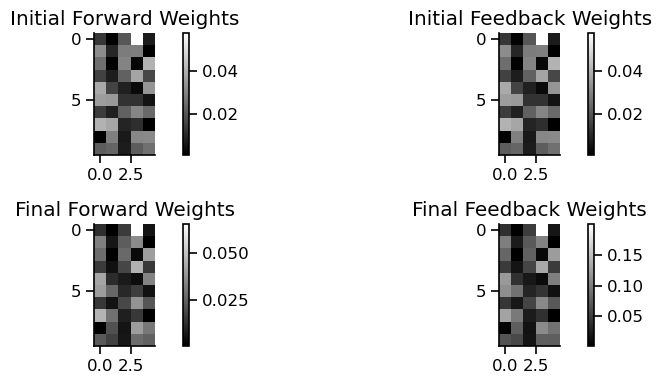

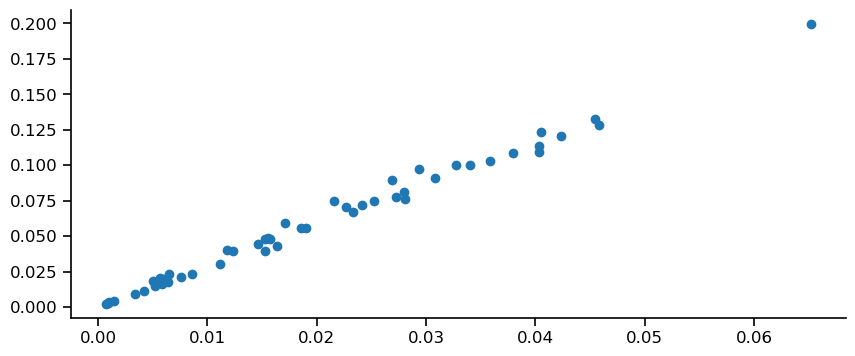

In [9]:
init_F = network.param_history[0]['module_dict.OutputE_InputE.weight']
init_B = network.param_history[0]['module_dict.InputE_OutputE.weight'].T
final_F = network.param_history[-1]['module_dict.OutputE_InputE.weight']
final_B = network.param_history[-1]['module_dict.InputE_OutputE.weight'].T

fig, ax  = plt.subplots(2,2, figsize=(10,4))
im = ax[0,0].imshow(init_F, cmap='gray')
ax[0,0].set_title("Initial Forward Weights")
cbar = fig.colorbar(im, ax=ax[0,0])
im = ax[0,1].imshow(init_B, cmap='gray')
ax[0,1].set_title("Initial Feedback Weights")
cbar = fig.colorbar(im, ax=ax[0,1])
im = ax[1,0].imshow(final_F, cmap='gray')
ax[1,0].set_title("Final Forward Weights")
cbar = fig.colorbar(im, ax=ax[1,0])
im = ax[1,1].imshow(final_B, cmap='gray')
ax[1,1].set_title("Final Feedback Weights")
cbar = fig.colorbar(im, ax=ax[1,1])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.scatter(final_F.flatten(), final_B.flatten())

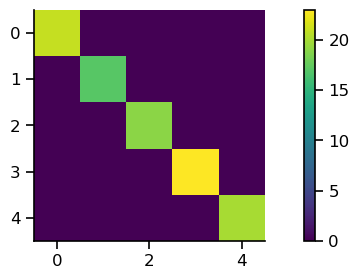

In [10]:
act = network.Input.E.activity_history
# cov_mat = np.cov(act.T)
cov_mat = np.matmul(act.T, act)
plt.imshow(cov_mat)
plt.colorbar()

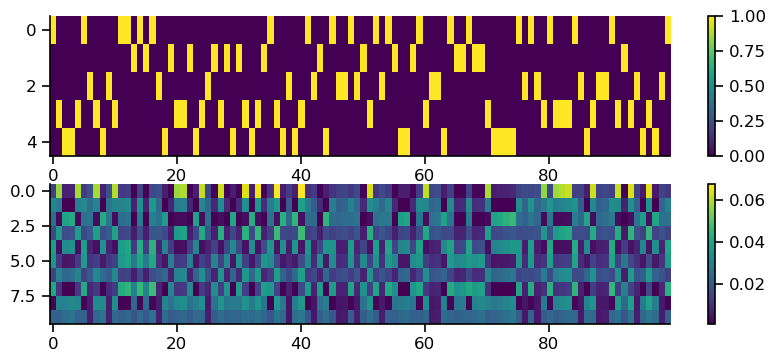

In [12]:
fig, ax = plt.subplots(2,1, figsize=(10,4))

im = ax[0].imshow(network.Input.E.activity_history.T, aspect='auto', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(network.Output.E.activity_history.T, aspect='auto', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax[1])
